In [1]:
%pip install pandas nvidia-ml-py transformers sentence-transformers lancedb pyarrow matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd 

In [ ]:
prod = pd.read_parquet("./esci-data/shopping_queries_dataset/shopping_queries_dataset_products.parquet")
prod.head()

In [ ]:
quer = pd.read_parquet("./esci-data/shopping_queries_dataset/shopping_queries_dataset_examples.parquet")
quer.head()

In [ ]:
df_examples_products = pd.merge(
    quer,
    prod,
    how='left',
    left_on=['product_locale','product_id'],
    right_on=['product_locale', 'product_id']
)
df_examples_products.head()

In [ ]:
df_examples_products_filter = df_examples_products[(df_examples_products['esci_label']=='E') & (df_examples_products['product_locale']=='us')]

In [ ]:
# Save some memory by loading the final subset in the future
df_examples_products_filter.to_parquet('./example_products.parquet')

In [3]:
df_examples_products_filter = pd.read_parquet('./example_products.parquet')

## Step 2: Prepare Data - Extract All Products and Create Evaluation Sample


In [4]:
print("Full Filtered Dataset:")
print(f"Total rows: {len(df_examples_products_filter)}")
print(f"Unique queries: {df_examples_products_filter['query'].nunique()}")
print(f"Unique products: {df_examples_products_filter['product_id'].nunique()}")
print(f"Average products per query: {len(df_examples_products_filter) / df_examples_products_filter['query'].nunique():.2f}")


Full Filtered Dataset:
Total rows: 1247558
Unique queries: 97344
Unique products: 904348
Average products per query: 12.82


In [5]:
import numpy as np

# Get all unique products from the full filtered dataset
df_all_products = df_examples_products_filter[['product_id', 'product_title', 'product_brand', 
                                                'product_description', 'product_bullet_point', 
                                                'product_color', 'product_locale']].drop_duplicates(subset=['product_id'])

print(f"\nTotal unique products for indexing: {len(df_all_products)}")



Total unique products for indexing: 904348


In [6]:
np.random.seed(42)  # For reproducibility

# First, identify queries that have at least 10 relevant items
query_counts = df_examples_products_filter.groupby('query')['product_id'].count()
queries_with_min_10 = query_counts[query_counts >= 10].index.tolist()

print(f"Queries with at least 10 relevant items: {len(queries_with_min_10)} out of {df_examples_products_filter['query'].nunique()}")

# Sample from queries that meet the minimum threshold
sample_queries = np.random.choice(queries_with_min_10, size=min(50, len(queries_with_min_10)), replace=False)

# Filter to get evaluation data (query-product pairs for these queries)
df_eval = df_examples_products_filter[df_examples_products_filter['query'].isin(sample_queries)]

print(f"\nEvaluation Data (before sampling to 500 rows):")
print(f"Sampled {len(sample_queries)} unique queries for evaluation")
print(f"Total query-product pairs: {len(df_eval)}")
print(f"Unique products in eval set: {df_eval['product_id'].nunique()}")

Queries with at least 10 relevant items: 66191 out of 97344

Evaluation Data (before sampling to 500 rows):
Sampled 50 unique queries for evaluation
Total query-product pairs: 809
Unique products in eval set: 809


In [7]:
def create_product_text(row):
    """Combine product fields into a single text for embedding"""
    parts = []
    
    # Add product title (most important)
    if pd.notna(row.get('product_title')):
        parts.append(str(row['product_title']))
    
    # Add product brand
    if pd.notna(row.get('product_brand')):
        parts.append(f"Brand: {row['product_brand']}")
    
    # Add product description if available 
    if pd.notna(row.get('product_description')):
        desc = str(row['product_description'])  
        parts.append(desc)
    
    # Add product bullet points if available 
    if pd.notna(row.get('product_bullet_point')):
        bullets = str(row['product_bullet_point'])  
        parts.append(bullets)
    
    return " | ".join(parts)

# Apply to ALL products for the index
print("Creating product text representations for ALL products...")
print(f"Processing {len(df_all_products)} products...")
df_all_products['product_text'] = df_all_products.apply(create_product_text, axis=1)

# Show an example
print("\nExample product text:")
print(df_all_products.iloc[0]['product_text'][:300] + "...")


Creating product text representations for ALL products...
Processing 904348 products...

Example product text:
Homewerks 7141-80 Bathroom Fan Integrated LED Light Ceiling Mount Exhaust Ventilation, 1.1 Sones, 80 CFM | Brand: Homewerks | OUTSTANDING PERFORMANCE: This Homewerk's bath fan ensures comfort in your home by quietly eliminating moisture and humidity in the bathroom. This exhaust fan is 1.1 sones at ...


## Step 3: Token Length Analysis

Analyze the token length distribution using different embedding model tokenizers to understand truncation impacts.


In [8]:
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
from tqdm import tqdm

sample_size = 10000
print(f"Total products available: {len(df_all_products):,}")
print(f"Using sample size: {sample_size:,} products for token analysis")

# Sample products randomly
df_sample_for_tokens = df_all_products.sample(n=min(sample_size, len(df_all_products)), random_state=42)

tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')


def calc_token_stats(df_sample_for_tokens, tokenizer):
    print("="*80)
    print("TOKEN LENGTH ANALYSIS")
    print("="*80)

    # Compute token lengths 
    print(f"Computing token lengths for {len(df_sample_for_tokens):,} products...")
    sample_texts = df_sample_for_tokens['product_text'].tolist()
    token_lens = []

    for text in tqdm(sample_texts, desc="Tokenizing", ncols=100):
        token_lens.append(len(tokenizer.encode(text, truncation=False, add_special_tokens=True)))

    # Calculate statistics
    token_stats = {
        'mean': np.mean(token_lens),
        'median': np.median(token_lens),
        'p90': np.percentile(token_lens, 90),
        'p95': np.percentile(token_lens, 95),
        'p99': np.percentile(token_lens, 99),
        'max': np.max(token_lens),
        'min': np.min(token_lens),
        'token_lens': token_lens
    }

    return token_stats, token_lens


token_stats, token_lens = calc_token_stats(df_sample_for_tokens, tokenizer)

print("\n" + "="*80)
print("TOKEN LENGTH STATISTICS (applies to ALL BERT-based models)")
print("="*80)
print(f"Mean:            {token_stats['mean']:.1f} tokens")
print(f"Median:          {token_stats['median']:.1f} tokens")
print(f"Min:             {token_stats['min']:.0f} tokens")
print(f"90th percentile: {token_stats['p90']:.0f} tokens")
print(f"95th percentile: {token_stats['p95']:.0f} tokens")
print(f"99th percentile: {token_stats['p99']:.0f} tokens")
print(f"Max:             {token_stats['max']:.0f} tokens")
print()
print(f"{(np.array(token_lens) > 512).mean() * 100:.1f}% of products exceed 512 tokens")
print(f"This affects ~{(np.array(token_lens) > 512).sum():,} out of {len(token_lens):,} sampled products")
print("="*80)


/opt/pytorch/lib/python3.12/site-packages/torch/cuda/__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


Total products available: 904,348
Using sample size: 10,000 products for token analysis
TOKEN LENGTH ANALYSIS
Computing token lengths for 10,000 products...


Tokenizing: 100%|███████████████████████████████████████████| 10000/10000 [00:06<00:00, 1498.54it/s]


TOKEN LENGTH STATISTICS (applies to ALL BERT-based models)
Mean:            288.1 tokens
Median:          207.0 tokens
Min:             3 tokens
90th percentile: 681 tokens
95th percentile: 811 tokens
99th percentile: 1009 tokens
Max:             2625 tokens

19.5% of products exceed 512 tokens
This affects ~1,950 out of 10,000 sampled products


### Field-Level Token Length Analysis

In [9]:
# Analyze token length contribution by field
print("="*80)
print("FIELD-LEVEL TOKEN LENGTH ANALYSIS")
print("="*80)
print(f"\nAnalyzing {len(df_sample_for_tokens)} products to understand token sources...\n")

# Tokenize individual fields
field_stats = {}

fields_to_analyze = {
    'product_title': 'Title',
    'product_brand': 'Brand',
    'product_description': 'Description',
    'product_bullet_point': 'Bullet Points'
}

for field_name, display_name in fields_to_analyze.items():
    field_texts = df_sample_for_tokens[field_name].fillna("").astype(str).tolist()
    field_token_lens = []
    
    for text in tqdm(field_texts, desc=f"  {display_name}", ncols=100, leave=False):
        # Count tokens including separators like " | "
        field_token_lens.append(len(tokenizer.encode(text, truncation=False, add_special_tokens=False)))
    
    field_stats[display_name] = {
        'token_lens': field_token_lens,
        'mean': np.mean(field_token_lens),
        'median': np.median(field_token_lens),
        'max': np.max(field_token_lens),
        'p95': np.percentile(field_token_lens, 95),
        'non_empty': sum(1 for x in field_token_lens if x > 0)
    }

print("\n" + "="*80)
print("TOKEN LENGTH BY FIELD")
print("="*80)
print(f"{'Field':<20} {'Mean':>8} {'Median':>8} {'95th %':>8} {'Max':>8} {'Non-Empty':>10}")
print("-"*80)

for field, stats in field_stats.items():
    print(f"{field:<20} {stats['mean']:>8.1f} {stats['median']:>8.1f} "
          f"{stats['p95']:>8.0f} {stats['max']:>8.0f} "
          f"{stats['non_empty']:>10,} ({stats['non_empty']/len(df_sample_for_tokens)*100:.1f}%)")

print("="*80)


FIELD-LEVEL TOKEN LENGTH ANALYSIS

Analyzing 10000 products to understand token sources...




TOKEN LENGTH BY FIELD
Field                    Mean   Median   95th %      Max  Non-Empty
--------------------------------------------------------------------------------
Title                    26.3     24.0       48      104     10,000 (100.0%)
Brand                     2.7      3.0        5       15      9,507 (95.1%)
Description             122.5     17.0      495     1168      5,335 (53.3%)
Bullet Points           130.3    105.0      349     1351      8,634 (86.3%)


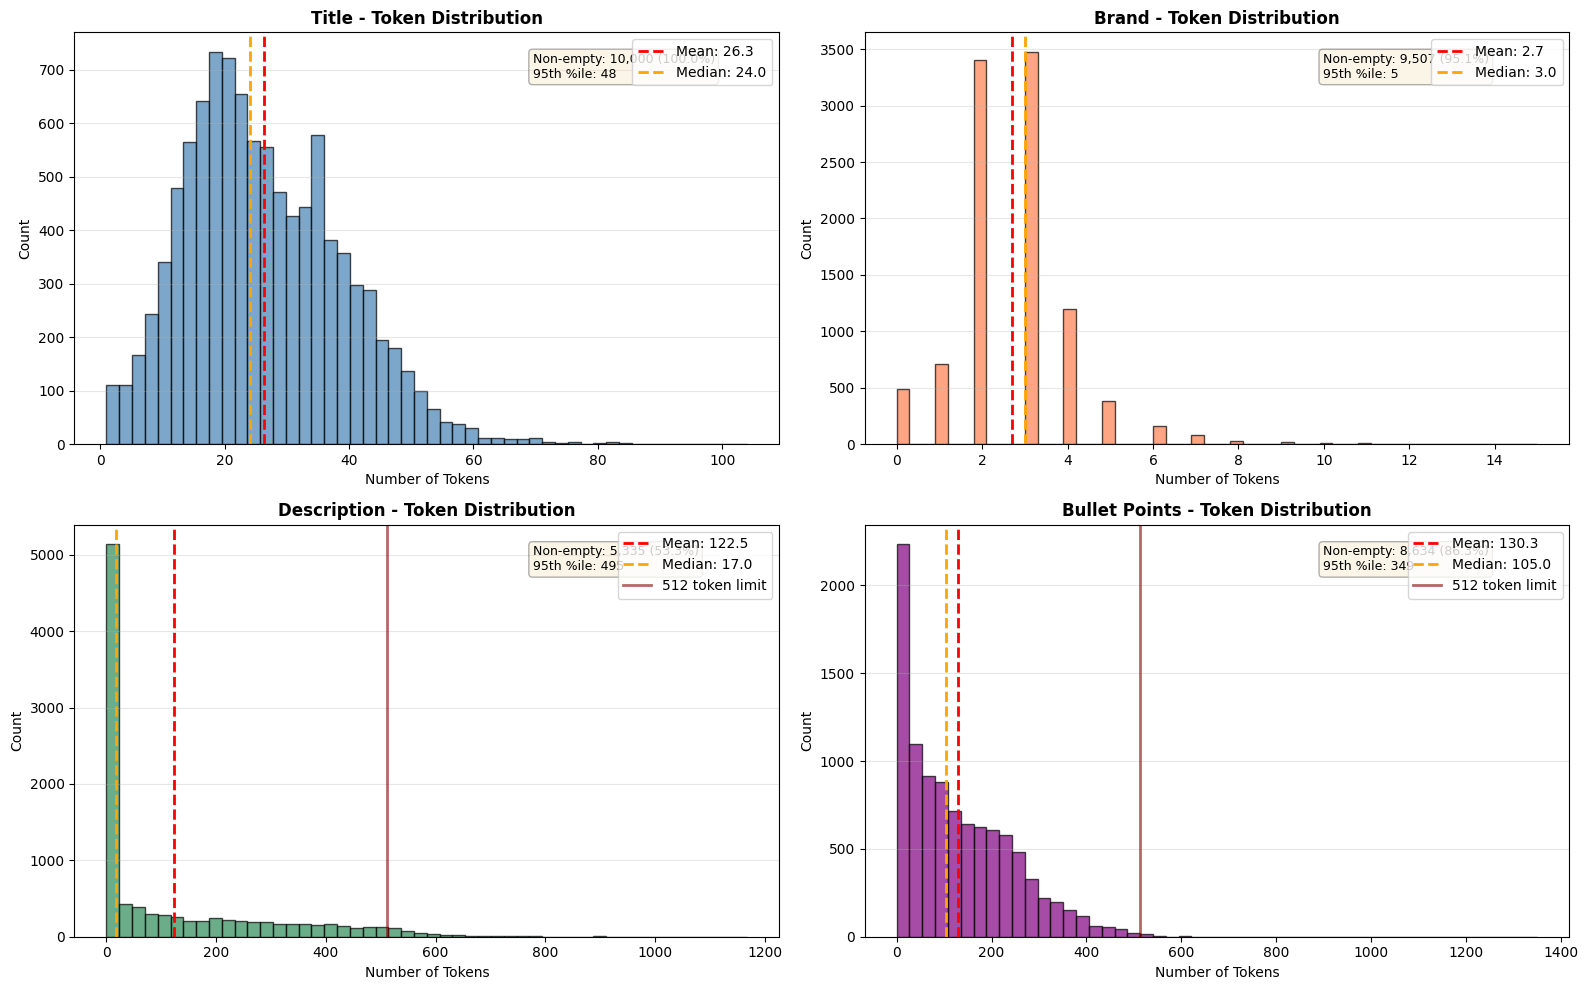

In [10]:
# Visualize field contribution
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

colors_fields = ['steelblue', 'coral', 'seagreen', 'purple']

for idx, (field_name, stats) in enumerate(field_stats.items()):
    ax = axes[idx]
    
    ax.hist(stats['token_lens'], bins=50, color=colors_fields[idx], edgecolor='black', alpha=0.7)
    ax.axvline(stats['mean'], color='red', linestyle='--', linewidth=2, 
               label=f"Mean: {stats['mean']:.1f}")
    ax.axvline(stats['median'], color='orange', linestyle='--', linewidth=2, 
               label=f"Median: {stats['median']:.1f}")
    
    # Add 512 token limit reference 
    if stats['max'] > 512:
        ax.axvline(512, color='darkred', linestyle='-', linewidth=2, 
                   label="512 token limit", alpha=0.6)
    
    ax.set_title(f"{field_name} - Token Distribution", fontsize=12, fontweight='bold')
    ax.set_xlabel("Number of Tokens", fontsize=10)
    ax.set_ylabel("Count", fontsize=10)
    ax.legend(loc='upper right')
    ax.grid(axis='y', alpha=0.3)
    
    # Add text with key stats
    textstr = f'Non-empty: {stats["non_empty"]:,} ({stats["non_empty"]/len(df_sample_for_tokens)*100:.1f}%)\n'
    textstr += f'95th %ile: {stats["p95"]:.0f}'
    ax.text(0.65, 0.95, textstr, transform=ax.transAxes, fontsize=9,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout()
plt.show()


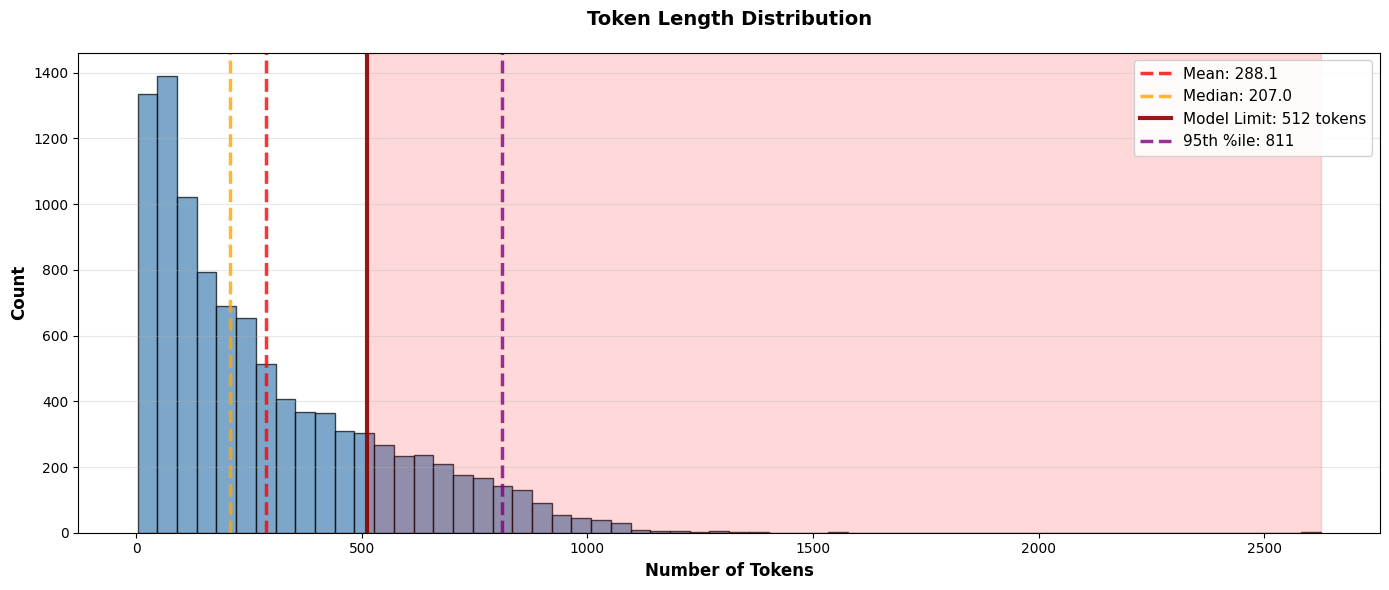


TOKEN LENGTH DISTRIBUTION SUMMARY
Sample Size:      10,000 products
Mean:             288.1 tokens
Median:           207.0 tokens
Standard Dev:     255.2 tokens
Min:              3 tokens
90th percentile:  681 tokens
95th percentile:  811 tokens
99th percentile:  1009 tokens
Max:              2625 tokens

Products > 512 tokens: 1,950 (19.5%)


In [11]:
# Visualize token length distribution
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

ax.hist(token_stats['token_lens'], bins=60, color='steelblue', edgecolor='black', alpha=0.7)

# Add reference lines
ax.axvline(token_stats['mean'], color='red', linestyle='--', linewidth=2.5, 
           label=f"Mean: {token_stats['mean']:.1f}", alpha=0.8)
ax.axvline(token_stats['median'], color='orange', linestyle='--', linewidth=2.5, 
           label=f"Median: {token_stats['median']:.1f}", alpha=0.8)
ax.axvline(512, color='darkred', linestyle='-', linewidth=3, 
           label=f"Model Limit: 512 tokens", alpha=0.9)
ax.axvline(token_stats['p95'], color='purple', linestyle='--', linewidth=2.5, 
           label=f"95th %ile: {token_stats['p95']:.0f}", alpha=0.8)

# Formatting
ax.set_title("Token Length Distribution", fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel("Number of Tokens", fontsize=12, fontweight='bold')
ax.set_ylabel("Count", fontsize=12, fontweight='bold')
ax.legend(loc='upper right', fontsize=11, framealpha=0.9)
ax.grid(axis='y', alpha=0.3)

# Add shaded region for truncated tokens
ax.axvspan(512, token_stats['max'], alpha=0.15, color='red', 
           label='_nolegend_')  # Shaded area showing truncation zone

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("TOKEN LENGTH DISTRIBUTION SUMMARY")
print("="*80)
print(f"Sample Size:      {len(token_stats['token_lens']):,} products")
print(f"Mean:             {token_stats['mean']:.1f} tokens")
print(f"Median:           {token_stats['median']:.1f} tokens")
print(f"Standard Dev:     {np.std(token_stats['token_lens']):.1f} tokens")
print(f"Min:              {token_stats['min']:.0f} tokens")
print(f"90th percentile:  {token_stats['p90']:.0f} tokens")
print(f"95th percentile:  {token_stats['p95']:.0f} tokens")
print(f"99th percentile:  {token_stats['p99']:.0f} tokens")
print(f"Max:              {token_stats['max']:.0f} tokens")
print()
print(f"Products > 512 tokens: {(np.array(token_stats['token_lens']) > 512).sum():,} ({(np.array(token_stats['token_lens']) > 512).mean() * 100:.1f}%)")
print("="*80)


In [12]:
def create_product_text_trunc(row):
    """Combine product fields into a single text for embedding"""
    parts = []
    
    # Add product title (most important)
    if pd.notna(row.get('product_title')):
        parts.append(str(row['product_title']))
    
    # Add product brand
    if pd.notna(row.get('product_brand')):
        parts.append(f"Brand: {row['product_brand']}")
    
    # Add product description if available
    if pd.notna(row.get('product_description')):
        desc = str(row['product_description'])[:500]
        parts.append(desc)
    
    # Add product bullet points if available
    if pd.notna(row.get('product_bullet_point')):
        bp = str(row['product_bullet_point'])[:500]
        parts.append(bp)
    
    return " | ".join(parts)

# Apply to ALL products for the index
print("Creating product text representations for ALL products...")
print(f"Processing {len(df_all_products)} products...")
df_all_products['product_text'] = df_all_products.apply(create_product_text_trunc, axis=1)

# Show an example
print("\nExample product text:")
print(df_all_products.iloc[0]['product_text'][:1000] + "...")

Creating product text representations for ALL products...
Processing 904348 products...

Example product text:
Homewerks 7141-80 Bathroom Fan Integrated LED Light Ceiling Mount Exhaust Ventilation, 1.1 Sones, 80 CFM | Brand: Homewerks | OUTSTANDING PERFORMANCE: This Homewerk's bath fan ensures comfort in your home by quietly eliminating moisture and humidity in the bathroom. This exhaust fan is 1.1 sones at 80 CFM which means it’s able to manage spaces up to 80 square feet and is very quiet..
BATH FANS HELPS REMOVE HARSH ODOR: When cleaning the bathroom or toilet, harsh chemicals are used and they can leave an obnoxious odor behind. Homewerk’s bathroom fans can help remove this odor with its powerful ventilation
BUILD QUALITY: ...


In [13]:
df_sample_for_tokens = df_all_products.sample(n=min(sample_size, len(df_all_products)), random_state=42)

token_stats, token_lens = calc_token_stats(df_sample_for_tokens, tokenizer)

TOKEN LENGTH ANALYSIS
Computing token lengths for 10,000 products...


Tokenizing: 100%|███████████████████████████████████████████| 10000/10000 [00:04<00:00, 2311.28it/s]


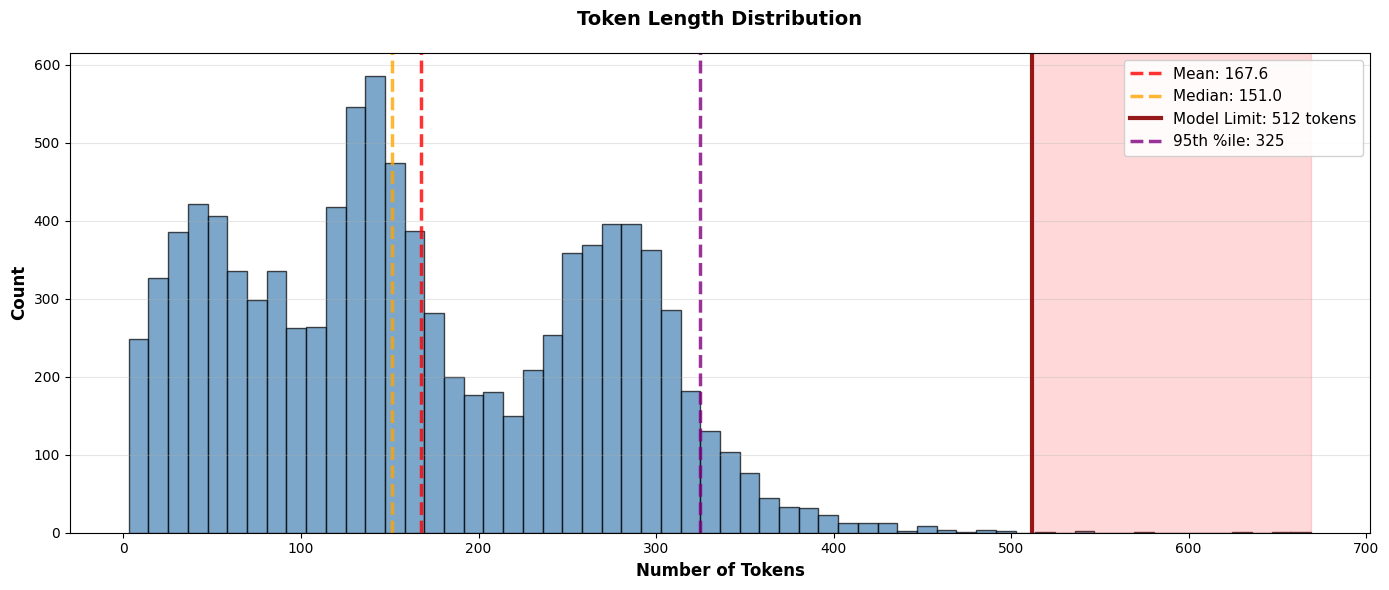


TOKEN LENGTH DISTRIBUTION SUMMARY
Sample Size:      10,000 products
Mean:             167.6 tokens
Median:           151.0 tokens
Standard Dev:     100.6 tokens
Min:              3 tokens
90th percentile:  301 tokens
95th percentile:  325 tokens
99th percentile:  387 tokens
Max:              669 tokens

Products > 512 tokens: 7 (0.1%)


In [14]:
# Visualize token length distribution of truncated text
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

ax.hist(token_stats['token_lens'], bins=60, color='steelblue', edgecolor='black', alpha=0.7)

# Add reference lines
ax.axvline(token_stats['mean'], color='red', linestyle='--', linewidth=2.5, 
           label=f"Mean: {token_stats['mean']:.1f}", alpha=0.8)
ax.axvline(token_stats['median'], color='orange', linestyle='--', linewidth=2.5, 
           label=f"Median: {token_stats['median']:.1f}", alpha=0.8)
ax.axvline(512, color='darkred', linestyle='-', linewidth=3, 
           label=f"Model Limit: 512 tokens", alpha=0.9)
ax.axvline(token_stats['p95'], color='purple', linestyle='--', linewidth=2.5, 
           label=f"95th %ile: {token_stats['p95']:.0f}", alpha=0.8)

# Formatting
ax.set_title("Token Length Distribution", fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel("Number of Tokens", fontsize=12, fontweight='bold')
ax.set_ylabel("Count", fontsize=12, fontweight='bold')
ax.legend(loc='upper right', fontsize=11, framealpha=0.9)
ax.grid(axis='y', alpha=0.3)

# Add shaded region for truncated tokens
ax.axvspan(512, token_stats['max'], alpha=0.15, color='red', 
           label='_nolegend_')  # Shaded area showing truncation zone

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("TOKEN LENGTH DISTRIBUTION SUMMARY")
print("="*80)
print(f"Sample Size:      {len(token_stats['token_lens']):,} products")
print(f"Mean:             {token_stats['mean']:.1f} tokens")
print(f"Median:           {token_stats['median']:.1f} tokens")
print(f"Standard Dev:     {np.std(token_stats['token_lens']):.1f} tokens")
print(f"Min:              {token_stats['min']:.0f} tokens")
print(f"90th percentile:  {token_stats['p90']:.0f} tokens")
print(f"95th percentile:  {token_stats['p95']:.0f} tokens")
print(f"99th percentile:  {token_stats['p99']:.0f} tokens")
print(f"Max:              {token_stats['max']:.0f} tokens")
print()
print(f"Products > 512 tokens: {(np.array(token_stats['token_lens']) > 512).sum():,} ({(np.array(token_stats['token_lens']) > 512).mean() * 100:.1f}%)")
print("="*80)


## Step 4: Build Vector Index with LanceDB


In [ ]:
# Initialize LanceDB
import os
import shutil
import lancedb

db_path = "./lancedb_products"
if os.path.exists(db_path):
    shutil.rmtree(db_path)
    
db = lancedb.connect(db_path)
print(f"LanceDB initialized at: {db_path}")


LanceDB initialized at: ./lancedb_products


## Step 5: Generate Embeddings for All Models

We'll test 4 different embedding models:
1. **all-MiniLM-L6-v2**: Because you have to (384 dims)
2. **bge-small-en-v1.5**: BGE small model (384 dims)  
3. **e5-small-v2**: E5 small model (384 dims)


In [ ]:
# Dictionary to store embeddings and models
embeddings_dict = {}
models_dict = {}
tables_dict = {}

# Define models with their HuggingFace paths
embedding_models = {
    'all-MiniLM-L6-v2': 'sentence-transformers/all-MiniLM-L6-v2',
    'bge-small-en-v1.5': 'BAAI/bge-small-en-v1.5',
    'e5-small-v2': 'intfloat/e5-small-v2'
}

product_texts = df_all_products['product_text'].tolist()

In [ ]:
import time
import gc
import os
from sentence_transformers import SentenceTransformer
import torch

# Create directory for saving embeddings
embeddings_dir = "./saved_embeddings"
os.makedirs(embeddings_dir, exist_ok=True)

for model_name, model_path in embedding_models.items():
    print(f"\n{'='*70}")
    print(f"Processing: {model_name}")
    print(f"{'='*70}")
    
    start_time = time.time()
    
    # Check if embeddings already exist
    embeddings_file = f"{embeddings_dir}/{model_name.replace('-', '_').replace('.', '_')}_embeddings.npy"
    
    if os.path.exists(embeddings_file):
        print(f"✓ Found saved embeddings at {embeddings_file}")
        print(f"Loading embeddings from disk...")
        embeddings = np.load(embeddings_file)
        print(f"  Loaded embeddings: {embeddings.shape}")
        
        # Load model (still needed for queries later)
        print(f"Loading model: {model_path}...")
        model = SentenceTransformer(model_path)
        models_dict[model_name] = model
    else:
        print(f"No saved embeddings found. Generating new embeddings...")
        print(f"Loading model: {model_path}...")
        model = SentenceTransformer(model_path)
        models_dict[model_name] = model
        
        print(f"Model loaded. Embedding dimension: {model.get_sentence_embedding_dimension()}")
        
        # Generate embeddings with normalization
        print(f"Generating embeddings (with normalization)...")
        embeddings = model.encode(
            product_texts, 
            show_progress_bar=True, 
            convert_to_numpy=True, 
            batch_size=256,  
            device='cuda',
            normalize_embeddings=True 
        )
        print(f"  Embeddings generated: {embeddings.shape}")
        
        # Save embeddings to disk
        print(f"Saving embeddings to {embeddings_file}...")
        np.save(embeddings_file, embeddings)
        print(f"  ✓ Embeddings saved!")
    
    # Create LanceDB table using batch processing
    print(f"Creating LanceDB table with batch processing...")
    table_name = f"products_{model_name.replace('-', '_').replace('.', '_')}"
    
    # Process in batches of 10,000 to avoid memory exhaustion
    BATCH_SIZE = 10000
    num_batches = (len(df_all_products) + BATCH_SIZE - 1) // BATCH_SIZE
    
    print(f"  Processing {len(df_all_products):,} products in {num_batches} batches...")
    
    for batch_idx in range(num_batches):
        start_idx = batch_idx * BATCH_SIZE
        end_idx = min((batch_idx + 1) * BATCH_SIZE, len(df_all_products))
        
        # Get batch of data
        df_batch = df_all_products.iloc[start_idx:end_idx]
        embeddings_batch = embeddings[start_idx:end_idx]
        
        # Create batch data list
        batch_data = [
            {
                "product_id": row.product_id,
                "product_title": row.product_title if pd.notna(row.product_title) else "",
                "product_brand": row.product_brand if pd.notna(row.product_brand) else "",
                "product_text": row.product_text,
                "vector": embeddings_batch[i].tolist()
            }
            for i, row in enumerate(df_batch.itertuples(index=False))
        ]
        
        # Create or append to table
        if batch_idx == 0:
            table = db.create_table(table_name, data=batch_data, mode="overwrite")
        else:
            table.add(batch_data)
        
        print(f"  Batch {batch_idx + 1}/{num_batches} complete ({end_idx:,}/{len(df_all_products):,} products)")
        
        # Clear batch data from memory
        del batch_data, df_batch, embeddings_batch
        gc.collect()
    
    tables_dict[model_name] = table
    
    # Create IVF-PQ index with cosine distance
    print(f"Creating IVF-PQ index with cosine distance...")
    index_start = time.time()
    table.create_index(
        metric="cosine",
        num_partitions=256,  # IVF: Number of partitions 
        num_sub_vectors=96,  # PQ: Product quantization subvectors (384/4)
        vector_column_name="vector"
    )
    index_elapsed = time.time() - index_start
    
    elapsed = time.time() - start_time
    print(f"✓ Completed in {elapsed:.1f} seconds")
    print(f"  Embedding shape: {embeddings.shape}")
    print(f"  Embeddings normalized: True")
    print(f"  Table created: {table_name} with {len(df_all_products):,} entries")
    print(f"  Index created in {index_elapsed:.1f} seconds (IVF-PQ with cosine distance)")
    
    # Memory cleanup between models
    print(f"  Cleaning up memory...")
    del embeddings  # Delete embeddings after table creation
    torch.cuda.empty_cache()
    gc.collect()

print(f"\n{'='*70}")
print("All embeddings generated and indexed!")
print(f"Saved embeddings directory: {embeddings_dir}")
print(f"{'='*70}")



Processing: all-MiniLM-L6-v2
✓ Found saved embeddings at ./saved_embeddings/all_MiniLM_L6_v2_embeddings.npy
Loading embeddings from disk...
  Loaded embeddings: (904348, 384)
Loading model: sentence-transformers/all-MiniLM-L6-v2...
Creating LanceDB table with batch processing...
  Processing 904,348 products in 91 batches...
  Batch 1/91 complete (10,000/904,348 products)
  Batch 2/91 complete (20,000/904,348 products)
  Batch 3/91 complete (30,000/904,348 products)
  Batch 4/91 complete (40,000/904,348 products)
  Batch 5/91 complete (50,000/904,348 products)
  Batch 6/91 complete (60,000/904,348 products)
  Batch 7/91 complete (70,000/904,348 products)
  Batch 8/91 complete (80,000/904,348 products)
  Batch 9/91 complete (90,000/904,348 products)
  Batch 10/91 complete (100,000/904,348 products)
  Batch 11/91 complete (110,000/904,348 products)
  Batch 12/91 complete (120,000/904,348 products)
  Batch 13/91 complete (130,000/904,348 products)
  Batch 14/91 complete (140,000/904,348 

## Step 5b: Create HNSW Indexes for Comparison


In [74]:
# Dictionary to store HNSW tables
hnsw_tables_dict = {}

print("="*70)
print("CREATING HNSW INDEXES")
print("="*70)
print(f"Models: {len(embedding_models)}")
print()

for i, (model_name, model_path) in enumerate(embedding_models.items(), 1):
    print(f"\n{'-'*70}")
    print(f"Model {i}/{len(embedding_models)}: {model_name}")
    print(f"{'-'*70}")
    
    table_name_hnsw = f"products_{model_name.replace('-', '_').replace('.', '_')}_hnsw"
    
    # Check if HNSW table already exists
    try:
        table_hnsw = db.open_table(table_name_hnsw)
        print(f"✓ Found existing HNSW table: {table_name_hnsw}")
        hnsw_tables_dict[model_name] = table_hnsw
        continue
    except Exception:
        print(f"Creating new HNSW table: {table_name_hnsw}")
    
    # Load embeddings
    embeddings_file = f"./saved_embeddings/{model_name.replace('-', '_').replace('.', '_')}_embeddings.npy"
    embeddings = np.load(embeddings_file)
    print(f"  Loaded embeddings: {embeddings.shape}")
    
    # Create table in batches (same data as IVF-PQ tables)
    BATCH_SIZE = 10000
    num_batches = (len(df_all_products) + BATCH_SIZE - 1) // BATCH_SIZE
    print(f"  Creating table in {num_batches} batches...")
    
    for batch_idx in range(num_batches):
        start_idx = batch_idx * BATCH_SIZE
        end_idx = min((batch_idx + 1) * BATCH_SIZE, len(df_all_products))
        
        df_batch = df_all_products.iloc[start_idx:end_idx]
        embeddings_batch = embeddings[start_idx:end_idx]
        
        batch_data = [
            {
                "product_id": row.product_id,
                "product_title": row.product_title if pd.notna(row.product_title) else "",
                "product_brand": row.product_brand if pd.notna(row.product_brand) else "",
                "product_text": row.product_text,
                "vector": embeddings_batch[i].tolist()
            }
            for i, row in enumerate(df_batch.itertuples(index=False))
        ]
        
        if batch_idx == 0:
            table_hnsw = db.create_table(table_name_hnsw, data=batch_data, mode="overwrite")
        else:
            table_hnsw.add(batch_data)
        
        if (batch_idx + 1) % 20 == 0:
            print(f"    Batch {batch_idx + 1}/{num_batches}")
        
        del batch_data, df_batch, embeddings_batch
        gc.collect()
    
    # Create HNSW index (different parameters from IVF-PQ!)
    print(f"  Creating HNSW index...")
    index_start = time.time()
    table_hnsw.create_index(
        metric="cosine",
        m=64,                         # HNSW: number of neighbors per vector
        ef_construction=400,          # HNSW: candidates to evaluate during construction
        vector_column_name="vector"
    )
    index_elapsed = time.time() - index_start
    
    hnsw_tables_dict[model_name] = table_hnsw
    print(f"  ✓ HNSW index created in {index_elapsed:.1f}s")
    print(f"  ✓ Table: {table_name_hnsw}")
    
    # Cleanup
    del embeddings
    torch.cuda.empty_cache()
    gc.collect()

print("\n" + "="*70)
print("HNSW INDEXES COMPLETE!")
print("="*70)
print(f"IVF-PQ tables:  {list(tables_dict.keys())}")
print(f"HNSW tables:    {list(hnsw_tables_dict.keys())}")
print("="*70)


CREATING HNSW INDEXES
Models: 3


----------------------------------------------------------------------
Model 1/3: all-MiniLM-L6-v2
----------------------------------------------------------------------
Creating new HNSW table: products_all_MiniLM_L6_v2_hnsw
  Loaded embeddings: (904348, 384)
  Creating table in 91 batches...


[2025-10-23T18:40:07Z WARN  lance::dataset::write::insert] No existing dataset at /home/ubuntu/environments/semantic-search-grainger/lancedb_products/products_all_MiniLM_L6_v2_hnsw.lance, it will be created


    Batch 20/91
    Batch 40/91
    Batch 60/91
    Batch 80/91
  Creating HNSW index...
  ✓ HNSW index created in 76.1s
  ✓ Table: products_all_MiniLM_L6_v2_hnsw

----------------------------------------------------------------------
Model 2/3: bge-small-en-v1.5
----------------------------------------------------------------------
Creating new HNSW table: products_bge_small_en_v1_5_hnsw
  Loaded embeddings: (904348, 384)
  Creating table in 91 batches...


[2025-10-23T18:42:25Z WARN  lance::dataset::write::insert] No existing dataset at /home/ubuntu/environments/semantic-search-grainger/lancedb_products/products_bge_small_en_v1_5_hnsw.lance, it will be created


    Batch 20/91
    Batch 40/91
    Batch 60/91
    Batch 80/91
  Creating HNSW index...
  ✓ HNSW index created in 69.7s
  ✓ Table: products_bge_small_en_v1_5_hnsw

----------------------------------------------------------------------
Model 3/3: e5-small-v2
----------------------------------------------------------------------
Creating new HNSW table: products_e5_small_v2_hnsw
  Loaded embeddings: (904348, 384)
  Creating table in 91 batches...


[2025-10-23T18:44:39Z WARN  lance::dataset::write::insert] No existing dataset at /home/ubuntu/environments/semantic-search-grainger/lancedb_products/products_e5_small_v2_hnsw.lance, it will be created


    Batch 20/91
    Batch 40/91
    Batch 60/91
    Batch 80/91
  Creating HNSW index...
  ✓ HNSW index created in 70.8s
  ✓ Table: products_e5_small_v2_hnsw

HNSW INDEXES COMPLETE!
IVF-PQ tables:  ['all-MiniLM-L6-v2', 'bge-small-en-v1.5', 'e5-small-v2']
HNSW tables:    ['all-MiniLM-L6-v2', 'bge-small-en-v1.5', 'e5-small-v2']


## Step 6: Comprehensive Evaluation Function


In [19]:
from typing import List, Set

def calculate_precision_at_k(relevant_items: Set[str], retrieved_items: List[str], k: int) -> float:
    """
    Calculate Precision@K: fraction of retrieved items (in top-k) that are relevant
    """
    retrieved_at_k = set(retrieved_items[:k])
    num_relevant_retrieved = len(retrieved_at_k.intersection(relevant_items))
    return num_relevant_retrieved / k if k > 0 else 0.0


def calculate_recall_at_k(relevant_items: Set[str], retrieved_items: List[str], k: int) -> float:
    """
    Calculate Recall@K: fraction of relevant items that were retrieved in top-k
    """
    if len(relevant_items) == 0:
        return 0.0
    retrieved_at_k = set(retrieved_items[:k])
    num_relevant_retrieved = len(retrieved_at_k.intersection(relevant_items))
    return num_relevant_retrieved / len(relevant_items)


def calculate_mrr(relevant_items: Set[str], retrieved_items: List[str]) -> float:
    """
    Calculate Mean Reciprocal Rank (MRR) for a single query
    Returns the reciprocal of the rank of the first relevant item
    """
    for rank, item in enumerate(retrieved_items, 1):
        if item in relevant_items:
            return 1.0 / rank
    return 0.0


def calculate_ndcg_at_k(relevant_items: Set[str], retrieved_items: List[str], k: int) -> float:
    """
    Calculate NDCG@K (Normalized Discounted Cumulative Gain)
    Measures ranking quality with higher scores for relevant items ranked higher
    
    Uses standard NDCG formula:
    - DCG = sum(rel_i / log2(i+1)) for i in 1 to k
    - IDCG = DCG of ideal ranking (all relevant items first)
    - NDCG = DCG / IDCG
    
    For binary relevance: rel_i = 1 if relevant, 0 otherwise
    """
    retrieved_at_k = retrieved_items[:k]
    
    # Calculate DCG (Discounted Cumulative Gain)
    dcg = 0.0
    for i, item in enumerate(retrieved_at_k, 1):
        if item in relevant_items:
            # Using binary relevance: rel = 1 if relevant, 0 otherwise
            dcg += 1.0 / np.log2(i + 1)
    
    # Calculate IDCG (Ideal DCG) - all relevant items ranked first
    num_relevant = len(relevant_items)
    idcg = 0.0
    for i in range(1, min(num_relevant, k) + 1):
        idcg += 1.0 / np.log2(i + 1)
    
    # Return NDCG
    if idcg == 0.0:
        return 0.0
    
    return dcg / idcg


In [20]:
def evaluate_model(model_name: str, table, model, df_eval: pd.DataFrame, k_values: List[int] = [1, 5, 10]) -> dict:
    """
    Comprehensive evaluation of a single model
    
    Args:
        model_name: Name of the model being evaluated
        table: LanceDB table for this model
        model: SentenceTransformer model
        df_eval: Evaluation dataframe with query and product_id columns
        k_values: List of k values to evaluate
        
    Returns:
        Dictionary with all metrics
    """
    # Group by query to get all relevant products for each query
    query_products = df_eval.groupby('query')['product_id'].apply(set).to_dict()
    
    # Initialize metrics storage
    metrics = {
        'precision': {k: [] for k in k_values},
        'recall': {k: [] for k in k_values},
        'ndcg': {k: [] for k in k_values},
        'mrr': []
    }
    
    print(f"Evaluating {model_name}...")
    print(f"Queries: {len(query_products)}")
    
    for i, (query, relevant_products) in enumerate(query_products.items()):
        # Generate query embedding (normalized for cosine similarity)
        query_embedding = model.encode(query, convert_to_numpy=True, normalize_embeddings=True)
        
        # Search in LanceDB
        max_k = max(k_values)
        search_results = table.search(query_embedding.tolist()).limit(max_k).to_list()
        retrieved_products = [r['product_id'] for r in search_results]
        
        # Calculate metrics for each k
        for k in k_values:
            precision = calculate_precision_at_k(relevant_products, retrieved_products, k)
            recall = calculate_recall_at_k(relevant_products, retrieved_products, k)
            ndcg = calculate_ndcg_at_k(relevant_products, retrieved_products, k)
            
            metrics['precision'][k].append(precision)
            metrics['recall'][k].append(recall)
            metrics['ndcg'][k].append(ndcg)
        
        # Calculate MRR (only once per query)
        mrr = calculate_mrr(relevant_products, retrieved_products)
        metrics['mrr'].append(mrr)
        
        # Progress indicator
        if (i + 1) % 10 == 0:
            print(f"  Processed {i + 1}/{len(query_products)} queries")
    
    # Calculate averages
    results = {
        'model': model_name,
        'mrr': np.mean(metrics['mrr'])
    }
    
    for k in k_values:
        results[f'precision@{k}'] = np.mean(metrics['precision'][k])
        results[f'recall@{k}'] = np.mean(metrics['recall'][k])
        results[f'ndcg@{k}'] = np.mean(metrics['ndcg'][k])
    
    return results

## Step 11: Index Type Comparison: Brute Force vs IVF-PQ vs HNSW


In [76]:
import time
import numpy as np

print("="*100)
print("SETUP: BRUTE FORCE TABLES (NO INDEX)")
print("="*100)
print(f"Creating tables WITHOUT indexes for comparison")
print(f"Models: {len(embedding_models)}")
print()

# Dictionary to store brute force tables
brute_force_tables = {}

for i, model_name in enumerate(embedding_models.keys(), 1):
    print(f"Model {i}/{len(embedding_models)}: {model_name}")
    
    table_name_no_index = f"products_{model_name.replace('-', '_').replace('.', '_')}_noindex"
    
    try:
        # Try to open existing table
        table_no_index = db.open_table(table_name_no_index)
        print(f"  ✓ Found existing: {table_name_no_index}")
        brute_force_tables[model_name] = table_no_index
    except Exception:
        # Create new table
        print(f"  Creating: {table_name_no_index} (~2-3 min)...")
        
        # Load embeddings
        embeddings_file = f"./saved_embeddings/{model_name.replace('-', '_').replace('.', '_')}_embeddings.npy"
        embeddings = np.load(embeddings_file)
        
        # Create table in batches WITHOUT index
        BATCH_SIZE = 10000
        num_batches = (len(df_all_products) + BATCH_SIZE - 1) // BATCH_SIZE
        
        for batch_idx in range(num_batches):
            start_idx = batch_idx * BATCH_SIZE
            end_idx = min((batch_idx + 1) * BATCH_SIZE, len(df_all_products))
            
            df_batch = df_all_products.iloc[start_idx:end_idx]
            embeddings_batch = embeddings[start_idx:end_idx]
            
            batch_data = [
                {
                    "product_id": row.product_id,
                    "product_title": row.product_title if pd.notna(row.product_title) else "",
                    "product_brand": row.product_brand if pd.notna(row.product_brand) else "",
                    "product_text": row.product_text,
                    "vector": embeddings_batch[j].tolist()
                }
                for j, row in enumerate(df_batch.itertuples(index=False))
            ]
            
            if batch_idx == 0:
                table_no_index = db.create_table(table_name_no_index, data=batch_data, mode="overwrite")
            else:
                table_no_index.add(batch_data)
            
            if (batch_idx + 1) % 20 == 0:
                print(f"    Batch {batch_idx + 1}/{num_batches}")
            
            del batch_data, df_batch, embeddings_batch
            gc.collect()
        
        brute_force_tables[model_name] = table_no_index
        print(f"  ✓ Created: {table_name_no_index}")
        del embeddings
        gc.collect()

print()
print("="*100)
print("ALL TABLES READY FOR COMPARISON")
print("="*100)
for model_name in embedding_models.keys():
    print(f"{model_name}:")
    print(f"  IVF-PQ:      products_{model_name.replace('-', '_').replace('.', '_')} (Cell 32)")
    print(f"  HNSW:        products_{model_name.replace('-', '_').replace('.', '_')}_hnsw (Cell 34)")
    print(f"  Brute Force: products_{model_name.replace('-', '_').replace('.', '_')}_noindex (above)")
print()
print("Total: 9 tables (3 models × 3 index types)")
print("="*100)


SETUP: BRUTE FORCE TABLES (NO INDEX)
Creating tables WITHOUT indexes for comparison
Models: 3

Model 1/3: all-MiniLM-L6-v2
  ✓ Found existing: products_all_MiniLM_L6_v2_noindex
Model 2/3: bge-small-en-v1.5
  ✓ Found existing: products_bge_small_en_v1_5_noindex
Model 3/3: e5-small-v2
  ✓ Found existing: products_e5_small_v2_noindex

ALL TABLES READY FOR COMPARISON
all-MiniLM-L6-v2:
  IVF-PQ:      products_all_MiniLM_L6_v2 (Cell 32)
  HNSW:        products_all_MiniLM_L6_v2_hnsw (Cell 34)
  Brute Force: products_all_MiniLM_L6_v2_noindex (above)
bge-small-en-v1.5:
  IVF-PQ:      products_bge_small_en_v1_5 (Cell 32)
  HNSW:        products_bge_small_en_v1_5_hnsw (Cell 34)
  Brute Force: products_bge_small_en_v1_5_noindex (above)
e5-small-v2:
  IVF-PQ:      products_e5_small_v2 (Cell 32)
  HNSW:        products_e5_small_v2_hnsw (Cell 34)
  Brute Force: products_e5_small_v2_noindex (above)

Total: 9 tables (3 models × 3 index types)


In [77]:
def evaluate_with_table(model, table, df_eval, table_type="Unknown", k_values=[1, 5, 10], index_type="brute_force"):
    """
    Evaluate model using a specific table (with or without index)
    Returns metrics and timing information
    
    Args:
        index_type: One of 'ivf_pq', 'hnsw', or 'brute_force'
                   - 'ivf_pq': Uses nprobes and refine_factor for IVF-PQ indexes
                   - 'hnsw': Simple search for HNSW indexes  
                   - 'brute_force': Simple search with no index
    """
    query_products = df_eval.groupby('query')['product_id'].apply(set).to_dict()
    
    metrics = {
        'precision': {k: [] for k in k_values},
        'recall': {k: [] for k in k_values},
        'ndcg': {k: [] for k in k_values},
        'mrr': []
    }
    
    search_times = []
    
    print(f"\nEvaluating with {table_type}...")
    print(f"Queries: {len(query_products)}")
    
    for i, (query, relevant_products) in enumerate(query_products.items()):
        # Generate query embedding (normalized)
        query_embedding = model.encode(query, convert_to_numpy=True, normalize_embeddings=True)
        
        # Measure search time
        max_k = max(k_values)
        start = time.time()
        
        # Use different query parameters based on index type
        if index_type == "ivf_pq":
            # IVF-PQ: Use nprobes and refine_factor for better accuracy
            search_results = table.search(query_embedding.tolist()).limit(max_k).nprobes(20).refine_factor(10).to_list()
        elif index_type == 'hnsw':
            search_results = table.search(query_embedding.tolist()).limit(max_k).ef(200).to_list()
        else:
            # HNSW or Brute Force: Simple search
            search_results = table.search(query_embedding.tolist()).limit(max_k).to_list()
        
        elapsed = time.time() - start
        search_times.append(elapsed)
        
        retrieved_products = [r['product_id'] for r in search_results]
        
        # Calculate metrics for each k
        for k in k_values:
            precision = calculate_precision_at_k(relevant_products, retrieved_products, k)
            recall = calculate_recall_at_k(relevant_products, retrieved_products, k)
            ndcg = calculate_ndcg_at_k(relevant_products, retrieved_products, k)
            
            metrics['precision'][k].append(precision)
            metrics['recall'][k].append(recall)
            metrics['ndcg'][k].append(ndcg)
        
        # Calculate MRR
        mrr = calculate_mrr(relevant_products, retrieved_products)
        metrics['mrr'].append(mrr)
        
        if (i + 1) % 10 == 0:
            print(f"  Processed {i + 1}/{len(query_products)} queries")
    
    # Calculate averages
    results = {
        'table_type': table_type,
        'mrr': np.mean(metrics['mrr']),
        'avg_latency_ms': np.mean(search_times) * 1000,
        'p50_latency_ms': np.percentile(search_times, 50) * 1000,
        'p95_latency_ms': np.percentile(search_times, 95) * 1000,
        'p99_latency_ms': np.percentile(search_times, 99) * 1000,
    }
    
    for k in k_values:
        results[f'precision@{k}'] = np.mean(metrics['precision'][k])
        results[f'recall@{k}'] = np.mean(metrics['recall'][k])
        results[f'ndcg@{k}'] = np.mean(metrics['ndcg'][k])
    
    return results

# Run evaluations for all 3 index types
print("\n" + "="*100)
print("RUNNING EVALUATIONS - ALL INDEX TYPES")
print("="*100)
print(f"Evaluating {len(embedding_models)} models × 3 index types = {len(embedding_models)*3} configurations")
print()

all_results = []

for i, model_name in enumerate(embedding_models.keys(), 1):
    print(f"\n{'-'*100}")
    print(f"MODEL {i}/{len(embedding_models)}: {model_name}")
    print(f"{'-'*100}")
    
    model = models_dict[model_name]
    
    # 1. Evaluate with Brute Force (no index)
    results_bf = evaluate_with_table(
        model, 
        brute_force_tables[model_name], 
        df_eval, 
        table_type=f"Brute Force - {model_name}",
        k_values=[1, 5, 10],
        index_type="brute_force"
    )
    results_bf['model'] = model_name
    results_bf['index_type'] = 'Brute Force'
    all_results.append(results_bf)
    
    # 2. Evaluate with IVF-PQ index
    results_ivfpq = evaluate_with_table(
        model, 
        tables_dict[model_name], 
        df_eval, 
        table_type=f"IVF-PQ - {model_name}",
        k_values=[1, 5, 10],
        index_type="ivf_pq"
    )
    results_ivfpq['model'] = model_name
    results_ivfpq['index_type'] = 'IVF-PQ'
    all_results.append(results_ivfpq)
    
    # 3. Evaluate with HNSW index
    results_hnsw = evaluate_with_table(
        model, 
        hnsw_tables_dict[model_name], 
        df_eval, 
        table_type=f"HNSW - {model_name}",
        k_values=[1, 5, 10],
        index_type="hnsw"
    )
    results_hnsw['model'] = model_name
    results_hnsw['index_type'] = 'HNSW'
    all_results.append(results_hnsw)

print("\n" + "="*100)
print("ALL EVALUATIONS COMPLETE!")
print("="*100)
print(f"✓ Evaluated 3 index types (Brute Force, IVF-PQ, HNSW)")
print(f"✓ Evaluated 3 models")
print(f"✓ Total: {len(all_results)} configurations")
print("="*100)



RUNNING EVALUATIONS - ALL INDEX TYPES
Evaluating 3 models × 3 index types = 9 configurations


----------------------------------------------------------------------------------------------------
MODEL 1/3: all-MiniLM-L6-v2
----------------------------------------------------------------------------------------------------

Evaluating with Brute Force - all-MiniLM-L6-v2...
Queries: 50
  Processed 10/50 queries
  Processed 20/50 queries
  Processed 30/50 queries
  Processed 40/50 queries
  Processed 50/50 queries

Evaluating with IVF-PQ - all-MiniLM-L6-v2...
Queries: 50
  Processed 10/50 queries
  Processed 20/50 queries
  Processed 30/50 queries
  Processed 40/50 queries
  Processed 50/50 queries

Evaluating with HNSW - all-MiniLM-L6-v2...
Queries: 50
  Processed 10/50 queries
  Processed 20/50 queries
  Processed 30/50 queries
  Processed 40/50 queries
  Processed 50/50 queries

----------------------------------------------------------------------------------------------------
MODEL

In [78]:
# Create comparison dataframe
df_all_comparisons = pd.DataFrame(all_results)

print("\n" + "="*100)
print("COMPARISON: BRUTE FORCE vs IVF-PQ vs HNSW - ALL MODELS")
print("="*100)
print()

# Display quality metrics
print("QUALITY METRICS (Higher is Better):")
print("-"*100)
quality_cols = ['model', 'index_type', 'mrr', 'precision@10', 'recall@10', 'ndcg@10']
print(df_all_comparisons[quality_cols].to_string(index=False, float_format='%.4f'))
print()

# Display performance metrics
print("PERFORMANCE METRICS (Lower is Better):")
print("-"*100)
perf_cols = ['model', 'index_type', 'avg_latency_ms', 'p95_latency_ms']
print(df_all_comparisons[perf_cols].to_string(index=False, float_format='%.2f'))
print()

# Per-model analysis with all 3 index types
print("="*100)
print("PER-MODEL ANALYSIS")
print("="*100)
print()

comparison_summary = []

for model_name in embedding_models.keys():
    df_model = df_all_comparisons[df_all_comparisons['model'] == model_name]
    bf_results = df_model[df_model['index_type'] == 'Brute Force'].iloc[0]
    ivfpq_results = df_model[df_model['index_type'] == 'IVF-PQ'].iloc[0]
    hnsw_results = df_model[df_model['index_type'] == 'HNSW'].iloc[0]
    
    print(f"{model_name}:")
    print(f"                  Brute Force    IVF-PQ         HNSW")
    print(f"  MRR:           {bf_results['mrr']:.4f}         {ivfpq_results['mrr']:.4f}         {hnsw_results['mrr']:.4f}")
    print(f"  Precision@10:  {bf_results['precision@10']:.4f}         {ivfpq_results['precision@10']:.4f}         {hnsw_results['precision@10']:.4f}")
    print(f"  NDCG@10:       {bf_results['ndcg@10']:.4f}         {ivfpq_results['ndcg@10']:.4f}         {hnsw_results['ndcg@10']:.4f}")
    print(f"  Avg Latency:   {bf_results['avg_latency_ms']:>6.1f}ms       {ivfpq_results['avg_latency_ms']:>6.1f}ms       {hnsw_results['avg_latency_ms']:>6.1f}ms")
    
    # Quality retention (vs brute force)
    ivfpq_quality = (ivfpq_results['ndcg@10'] / bf_results['ndcg@10']) * 100
    hnsw_quality = (hnsw_results['ndcg@10'] / bf_results['ndcg@10']) * 100
    
    # Speedup (vs brute force)
    ivfpq_speedup = bf_results['avg_latency_ms'] / ivfpq_results['avg_latency_ms']
    hnsw_speedup = bf_results['avg_latency_ms'] / hnsw_results['avg_latency_ms']
    
    print(f"  Quality:       100.0%          {ivfpq_quality:.1f}%          {hnsw_quality:.1f}%")
    print(f"  Speedup:       1.0x            {ivfpq_speedup:.1f}x            {hnsw_speedup:.1f}x")
    print()
    
    comparison_summary.append({
        'model': model_name,
        'ivfpq_quality_pct': ivfpq_quality,
        'hnsw_quality_pct': hnsw_quality,
        'ivfpq_speedup': ivfpq_speedup,
        'hnsw_speedup': hnsw_speedup
    })

df_summary = pd.DataFrame(comparison_summary)

print("="*100)
print("OVERALL SUMMARY")
print("="*100)
print()
print("Average Quality Retention ndcg@10 (vs Brute Force = 100%):")
print(f"  IVF-PQ: {df_summary['ivfpq_quality_pct'].mean():.1f}%")
print(f"  HNSW:   {df_summary['hnsw_quality_pct'].mean():.1f}%")
print()
print("Average Speedup (vs Brute Force = 1.0x):")
print(f"  IVF-PQ: {df_summary['ivfpq_speedup'].mean():.1f}x faster")
print(f"  HNSW:   {df_summary['hnsw_speedup'].mean():.1f}x faster")
print()


COMPARISON: BRUTE FORCE vs IVF-PQ vs HNSW - ALL MODELS

QUALITY METRICS (Higher is Better):
----------------------------------------------------------------------------------------------------
            model  index_type    mrr  precision@10  recall@10  ndcg@10
 all-MiniLM-L6-v2 Brute Force 0.5713        0.3220     0.2022   0.3541
 all-MiniLM-L6-v2      IVF-PQ 0.5713        0.3160     0.1982   0.3501
 all-MiniLM-L6-v2        HNSW 0.4955        0.2440     0.1538   0.2739
bge-small-en-v1.5 Brute Force 0.5472        0.3180     0.2122   0.3441
bge-small-en-v1.5      IVF-PQ 0.5258        0.3040     0.1989   0.3293
bge-small-en-v1.5        HNSW 0.4532        0.2360     0.1465   0.2596
      e5-small-v2 Brute Force 0.5617        0.3560     0.2358   0.3796
      e5-small-v2      IVF-PQ 0.5374        0.3260     0.2104   0.3523
      e5-small-v2        HNSW 0.4024        0.2460     0.1561   0.2569

PERFORMANCE METRICS (Lower is Better):
--------------------------------------------------------

## Comprehensive Visualization: Model Comparison Across Metrics


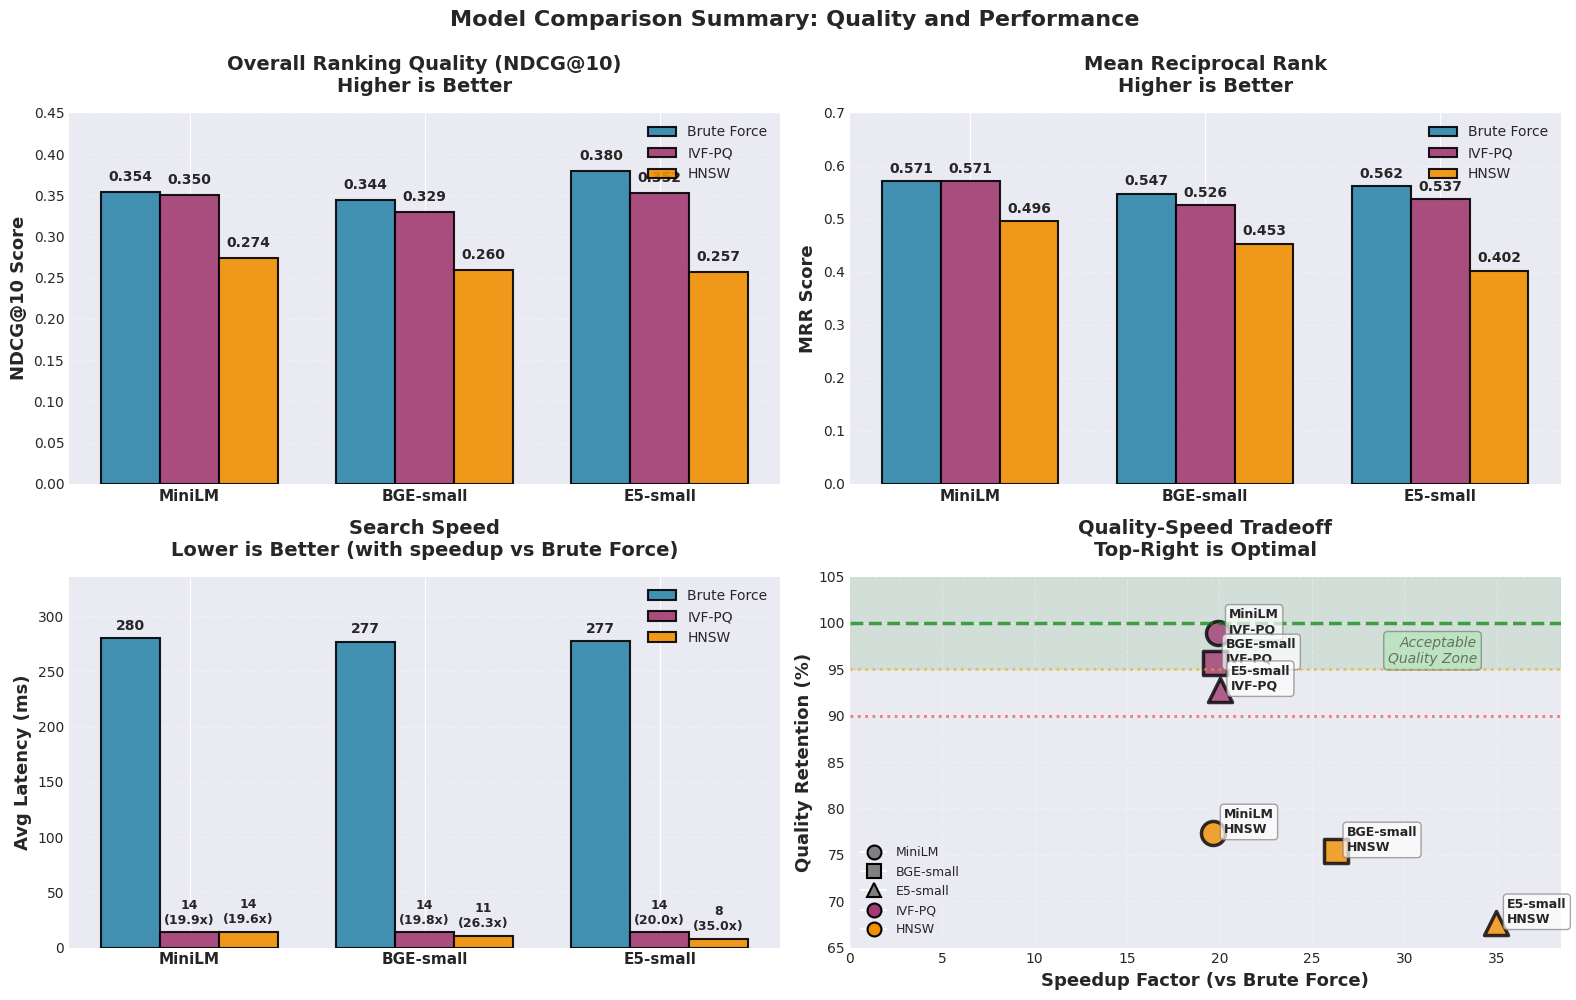

In [81]:
# Create a cleaner, more focused comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

models = list(embedding_models.keys())
model_labels = ['MiniLM', 'BGE-small', 'E5-small']
x = np.arange(len(models))
width = 0.25

# Define consistent colors
colors = {'Brute Force': '#2E86AB', 'IVF-PQ': '#A23B72', 'HNSW': '#F18F01'}

# 1. Overall Quality (NDCG@10) - Top Left
ax1 = axes[0, 0]
ndcg_bf = [df_all_comparisons[(df_all_comparisons['model'] == m) & (df_all_comparisons['index_type'] == 'Brute Force')]['ndcg@10'].values[0] for m in models]
ndcg_ivfpq = [df_all_comparisons[(df_all_comparisons['model'] == m) & (df_all_comparisons['index_type'] == 'IVF-PQ')]['ndcg@10'].values[0] for m in models]
ndcg_hnsw = [df_all_comparisons[(df_all_comparisons['model'] == m) & (df_all_comparisons['index_type'] == 'HNSW')]['ndcg@10'].values[0] for m in models]

bars1 = ax1.bar(x - width, ndcg_bf, width, label='Brute Force', color=colors['Brute Force'], alpha=0.9, edgecolor='black', linewidth=1.5)
bars2 = ax1.bar(x, ndcg_ivfpq, width, label='IVF-PQ', color=colors['IVF-PQ'], alpha=0.9, edgecolor='black', linewidth=1.5)
bars3 = ax1.bar(x + width, ndcg_hnsw, width, label='HNSW', color=colors['HNSW'], alpha=0.9, edgecolor='black', linewidth=1.5)

# Add value labels
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

ax1.set_ylabel('NDCG@10 Score', fontsize=13, fontweight='bold')
ax1.set_title('Overall Ranking Quality (NDCG@10)\nHigher is Better', fontsize=14, fontweight='bold', pad=15)
ax1.set_xticks(x)
ax1.set_xticklabels(model_labels, fontsize=11, fontweight='bold')
ax1.legend(fontsize=10, framealpha=0.95, loc='upper right')
ax1.grid(axis='y', alpha=0.3, linestyle='--')
ax1.set_ylim(0, 0.45)

# 2. MRR - Top Right
ax2 = axes[0, 1]
mrr_bf = [df_all_comparisons[(df_all_comparisons['model'] == m) & (df_all_comparisons['index_type'] == 'Brute Force')]['mrr'].values[0] for m in models]
mrr_ivfpq = [df_all_comparisons[(df_all_comparisons['model'] == m) & (df_all_comparisons['index_type'] == 'IVF-PQ')]['mrr'].values[0] for m in models]
mrr_hnsw = [df_all_comparisons[(df_all_comparisons['model'] == m) & (df_all_comparisons['index_type'] == 'HNSW')]['mrr'].values[0] for m in models]

bars1 = ax2.bar(x - width, mrr_bf, width, label='Brute Force', color=colors['Brute Force'], alpha=0.9, edgecolor='black', linewidth=1.5)
bars2 = ax2.bar(x, mrr_ivfpq, width, label='IVF-PQ', color=colors['IVF-PQ'], alpha=0.9, edgecolor='black', linewidth=1.5)
bars3 = ax2.bar(x + width, mrr_hnsw, width, label='HNSW', color=colors['HNSW'], alpha=0.9, edgecolor='black', linewidth=1.5)

for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

ax2.set_ylabel('MRR Score', fontsize=13, fontweight='bold')
ax2.set_title('Mean Reciprocal Rank\nHigher is Better', fontsize=14, fontweight='bold', pad=15)
ax2.set_xticks(x)
ax2.set_xticklabels(model_labels, fontsize=11, fontweight='bold')
ax2.legend(fontsize=10, framealpha=0.95, loc='upper right')
ax2.grid(axis='y', alpha=0.3, linestyle='--')
ax2.set_ylim(0, 0.7)

# 3. Search Latency - Bottom Left
ax3 = axes[1, 0]
lat_bf = [df_all_comparisons[(df_all_comparisons['model'] == m) & (df_all_comparisons['index_type'] == 'Brute Force')]['avg_latency_ms'].values[0] for m in models]
lat_ivfpq = [df_all_comparisons[(df_all_comparisons['model'] == m) & (df_all_comparisons['index_type'] == 'IVF-PQ')]['avg_latency_ms'].values[0] for m in models]
lat_hnsw = [df_all_comparisons[(df_all_comparisons['model'] == m) & (df_all_comparisons['index_type'] == 'HNSW')]['avg_latency_ms'].values[0] for m in models]

bars1 = ax3.bar(x - width, lat_bf, width, label='Brute Force', color=colors['Brute Force'], alpha=0.9, edgecolor='black', linewidth=1.5)
bars2 = ax3.bar(x, lat_ivfpq, width, label='IVF-PQ', color=colors['IVF-PQ'], alpha=0.9, edgecolor='black', linewidth=1.5)
bars3 = ax3.bar(x + width, lat_hnsw, width, label='HNSW', color=colors['HNSW'], alpha=0.9, edgecolor='black', linewidth=1.5)

# Add value labels and speedup annotations
for j, bar in enumerate(bars1):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 5,
            f'{height:.0f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

for j, bar in enumerate(bars2):
    height = bar.get_height()
    speedup = lat_bf[j] / height
    ax3.text(bar.get_x() + bar.get_width()/2., height + 5,
            f'{height:.0f}\n({speedup:.1f}x)', ha='center', va='bottom', fontsize=9, fontweight='bold')

for j, bar in enumerate(bars3):
    height = bar.get_height()
    speedup = lat_bf[j] / height
    ax3.text(bar.get_x() + bar.get_width()/2., height + 5,
            f'{height:.0f}\n({speedup:.1f}x)', ha='center', va='bottom', fontsize=9, fontweight='bold')

ax3.set_ylabel('Avg Latency (ms)', fontsize=13, fontweight='bold')
ax3.set_title('Search Speed\nLower is Better (with speedup vs Brute Force)', fontsize=14, fontweight='bold', pad=15)
ax3.set_xticks(x)
ax3.set_xticklabels(model_labels, fontsize=11, fontweight='bold')
ax3.legend(fontsize=10, framealpha=0.95, loc='upper right')
ax3.grid(axis='y', alpha=0.3, linestyle='--')
ax3.set_ylim(0, max(lat_bf) * 1.2)

# 4. Quality vs Speed Tradeoff - Bottom Right
ax4 = axes[1, 1]

# Plot each model with different markers
markers = {'all-MiniLM-L6-v2': 'o', 'bge-small-en-v1.5': 's', 'e5-small-v2': '^'}
marker_labels = {'all-MiniLM-L6-v2': 'MiniLM', 'bge-small-en-v1.5': 'BGE-small', 'e5-small-v2': 'E5-small'}

for i, model in enumerate(models):
    for idx_type in ['IVF-PQ', 'HNSW']:
        row = df_all_comparisons[
            (df_all_comparisons['model'] == model) & 
            (df_all_comparisons['index_type'] == idx_type)
        ].iloc[0]
        
        bf_row = df_all_comparisons[
            (df_all_comparisons['model'] == model) & 
            (df_all_comparisons['index_type'] == 'Brute Force')
        ].iloc[0]
        
        quality = (row['ndcg@10'] / bf_row['ndcg@10']) * 100
        speedup = bf_row['avg_latency_ms'] / row['avg_latency_ms']
        
        ax4.scatter(speedup, quality, s=300, alpha=0.8, 
                   color=colors[idx_type], marker=markers[model], 
                   edgecolors='black', linewidths=2.5,
                   label=f"{marker_labels[model]} - {idx_type}" if i == 0 else "")
        
        # Add labels
        ax4.annotate(f"{marker_labels[model]}\n{idx_type}", 
                    (speedup, quality), 
                    xytext=(8, 0), 
                    textcoords='offset points', 
                    fontsize=9, fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7, edgecolor='gray'))

# Add reference lines
ax4.axhline(y=100, color='green', linestyle='--', linewidth=2.5, alpha=0.7, label='100% quality (Brute Force)', zorder=1)
ax4.axhline(y=95, color='orange', linestyle=':', linewidth=2, alpha=0.6, label='95% quality threshold', zorder=1)
ax4.axhline(y=90, color='red', linestyle=':', linewidth=2, alpha=0.5, label='90% quality threshold', zorder=1)

# Shade the "good" region
ax4.axhspan(95, 105, alpha=0.1, color='green', zorder=0)
ax4.text(ax4.get_xlim()[1] * 0.95, 97, 'Acceptable\nQuality Zone', 
        ha='right', va='center', fontsize=10, style='italic', alpha=0.6,
        bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.3))

ax4.set_xlabel('Speedup Factor (vs Brute Force)', fontsize=13, fontweight='bold')
ax4.set_ylabel('Quality Retention (%)', fontsize=13, fontweight='bold')
ax4.set_title('Quality-Speed Tradeoff\nTop-Right is Optimal', fontsize=14, fontweight='bold', pad=15)
ax4.grid(True, alpha=0.3, linestyle='--')
ax4.set_ylim(65, 105)
ax4.set_xlim(0, max(speedup * 1.1 for speedup in [bf_lat / hnsw_lat for bf_lat, hnsw_lat in zip(lat_bf, lat_hnsw)]))

# Custom legend for markers and colors
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=10, label='MiniLM', markeredgecolor='black', markeredgewidth=1.5),
    Line2D([0], [0], marker='s', color='w', markerfacecolor='gray', markersize=10, label='BGE-small', markeredgecolor='black', markeredgewidth=1.5),
    Line2D([0], [0], marker='^', color='w', markerfacecolor='gray', markersize=10, label='E5-small', markeredgecolor='black', markeredgewidth=1.5),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['IVF-PQ'], markersize=10, label='IVF-PQ', markeredgecolor='black', markeredgewidth=1.5),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['HNSW'], markersize=10, label='HNSW', markeredgecolor='black', markeredgewidth=1.5),
]
ax4.legend(handles=legend_elements, loc='lower left', fontsize=9, framealpha=0.95, ncol=1)

plt.suptitle('Model Comparison Summary: Quality and Performance', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()




## Step 9: Query-Level Analysis

Let's look at a few sample queries to understand how different models perform on the same queries.

In [80]:

def compare_models_on_query(query: str, df_eval: pd.DataFrame, top_k: int = 5, index_type: str = "ivf_pq"):
    """
    Compare all models on a single query
    
    Args:
        query: Query string to search for
        df_eval: Evaluation dataframe with ground truth
        top_k: Number of results to retrieve
        index_type: Type of index to use ('ivf_pq', 'hnsw', or 'brute_force')
    """
    # Get ground truth
    ground_truth = set(df_eval[df_eval['query'] == query]['product_id'].tolist())
    
    if len(ground_truth) == 0:
        print(f"No ground truth found for query: '{query}'")
        return
    
    # Select appropriate tables based on index_type
    if index_type == "ivf_pq":
        tables_to_use = tables_dict
        index_label = "IVF-PQ"
    elif index_type == "hnsw":
        tables_to_use = hnsw_tables_dict
        index_label = "HNSW"
    elif index_type == "brute_force":
        tables_to_use = brute_force_tables
        index_label = "Brute Force"
    else:
        raise ValueError(f"Unknown index_type: {index_type}. Use 'ivf_pq', 'hnsw', or 'brute_force'")
    
    print(f"\n{'='*100}")
    print(f"Query: '{query}'")
    print(f"Ground Truth: {len(ground_truth)} relevant products")
    print(f"Index Type: {index_label}")
    print(f"{'='*100}\n")
    
    for model_name in embedding_models.keys():
        print(f"{model_name}:")
        print("-" * 100)
        
        # Get model and table
        model = models_dict[model_name]
        table = tables_to_use[model_name]
        
        # Generate query embedding (normalized for cosine similarity)
        query_embedding = model.encode(query, convert_to_numpy=True, normalize_embeddings=True)
        
        # Use different query parameters based on index type
        if index_type == "ivf_pq":
            # IVF-PQ: Use nprobes and refine_factor for better accuracy
            results = table.search(query_embedding.tolist()).limit(top_k).nprobes(20).refine_factor(10).to_list()
        elif index_type == "hnsw":
            # HNSW: Use ef parameter for search quality
            results = table.search(query_embedding.tolist()).limit(top_k).ef(300).to_list()
        else:
            # Brute Force: Simple search
            results = table.search(query_embedding.tolist()).limit(top_k).to_list()
        
        # Calculate metrics
        retrieved_ids = [r['product_id'] for r in results]
        precision = calculate_precision_at_k(ground_truth, retrieved_ids, top_k)
        recall = calculate_recall_at_k(ground_truth, retrieved_ids, top_k)
        mrr = calculate_mrr(ground_truth, retrieved_ids)
        ndcg = calculate_ndcg_at_k(ground_truth, retrieved_ids, top_k)
        
        print(f"Metrics: Precision@{top_k}={precision:.3f}, Recall@{top_k}={recall:.3f}, MRR={mrr:.3f}, NDCG@{top_k}={ndcg:.3f}")
        print(f"\nTop {top_k} Results:")
        
        for i, result in enumerate(results, 1):
            match = "✓" if result['product_id'] in ground_truth else "✗"
            print(f"  {i}. {match} {result['product_title'][:80]}...")
        
        print()

# Test on a few sample queries with IVF-PQ (default)
sample_queries_to_test = df_eval['query'].unique()[:3]

for query in sample_queries_to_test:
    compare_models_on_query(query, df_eval, top_k=5, index_type="ivf_pq")



Query: '1 belt strap without buckle'
Ground Truth: 34 relevant products
Index Type: IVF-PQ

all-MiniLM-L6-v2:
----------------------------------------------------------------------------------------------------
Metrics: Precision@5=0.200, Recall@5=0.029, MRR=0.333, NDCG@5=0.170

Top 5 Results:
  1. ✗ Mens Ratchet Belt Without Buckle Single Belt No Buckle Cowhide Leather Belt Oran...
  2. ✗ HJones Leather Belt for Belt Buckle Men's, 1.5" Replacement Belt Strap Without B...
  3. ✓ KAERMU Men's Leather Ratchet Belt Strap Only 30mm 1 1/8,Leather Belt without Buc...
  4. ✗ Thin Leather Belt Strap with Embossed Western Scrollwork 1" Wide with Snaps (Bro...
  5. ✗ Buckle Free Comfortable Elastic Belt for Women or Men, Buckle-less No Bulge No H...

bge-small-en-v1.5:
----------------------------------------------------------------------------------------------------
Metrics: Precision@5=0.400, Recall@5=0.059, MRR=0.500, NDCG@5=0.384

Top 5 Results:
  1. ✗ Mens Ratchet Belt Without Buckle Sing